In [1]:
import torch
from resource_loader import ResourceLoader
torch.set_grad_enabled(False)
import os
import gc

dataset="openwebtext" 
device="cpu"
gpt1_ckpt_dir="out_1_4_128_new"
sae1_ckpt_dir="1712550285.2"

In [2]:
resourceloader1 = ResourceLoader(
                    dataset=dataset,
                    gpt_ckpt_dir="out_1_4_128_new",
                    mode="eval",
                    sae_ckpt_dir="1712550285.2",
                    device=device,
                    )

train.bin not found; attempting to find val.bin
number of parameters: 6.64M


In [3]:
def forward_pass(gpt, sae, x):
    n_features = sae.n_latents
    _, _ = gpt(x)
    mlp_acts = gpt.mlp_activation_hooks[0]
    gpt.clear_mlp_activation_hooks()
    latents = sae.encode(mlp_acts).view(-1, n_features)
    return latents

In [4]:
def compute_latents(resourceloader1, num_batches = 1, gpt_batch_size = 12, seed=94, dtype=torch.float32):
    gpt1, sae1 = resourceloader1.transformer, resourceloader1.autoencoder


    n_features = sae1.n_latents
    block_size = gpt1.config.block_size

    sae1.initiate_dead_neurons()

    latents1 = torch.zeros(num_batches * gpt_batch_size * block_size, n_features, dtype=dtype)

    for i in range(num_batches):
        if i % 10 == 0 or i == num_batches-1:
            print(f"working on batch {i}")

        x, _ = resourceloader1.get_text_batch(num_contexts=gpt_batch_size)
        batch_latents1 = forward_pass(gpt1, sae1, x).to(device="cpu")# (B*T, L)

        sae1.update_dead_neurons(batch_latents1)

        latents1[i * gpt_batch_size * block_size : (i+1) * gpt_batch_size * block_size] = batch_latents1

    del x, batch_latents1; torch.cuda.empty_cache(); gc.collect()

    # remove dead neurons
    _, alive_neurons1 = sae1._get_neuron_indices()

    # specify indices of latents1 that correspond to alive2

    return latents1, alive_neurons1

In [35]:
def standardize(data):
    """ Standardize the data to have mean 0 and standard deviation 1 along the first axis """
    mean = data.mean(dim=0, keepdim=True)
    std = data.std(dim=0, keepdim=True, unbiased=False)
    return (data - mean) / std

def compute_corr_matrix(latents1, latents2):

    assert latents1.shape[0] == latents2.shape[0], "number of data points need to be the same"
    # TODO: understand where in the definiton of number of data points is this important 

    # Standardize latents1 and latents2
    latents1_standard = standardize(latents1)
    latents2_standard = standardize(latents2)

    # TODO: decide whether to divide by latents1.shape[0] or latents1.shape[0] - 1
    # Compute the dot product of the transposes of the standardized matrices
    corr_matrix = torch.mm(latents1_standard.t(), latents2_standard) / (latents1.shape[0])

    print(f"correlation_matrix has shape: {corr_matrix.shape}")

    return corr_matrix

In [36]:
latents1, alive1 = compute_latents(resourceloader1, num_batches=12, gpt_batch_size=1) 

working on batch 0
working on batch 10
working on batch 11


In [37]:
# about 16% features are dead
latents1.shape, alive1.shape[0], alive1.shape[0] / latents1.shape[-1]

(torch.Size([12288, 4096]), 3585, 0.875244140625)

In [38]:
# compute correlation matrix of alive neurons
correlation_matrix = compute_corr_matrix(latents1[:, alive1], latents1[:, alive1])

correlation_matrix has shape: torch.Size([3585, 3585])


In [39]:
# correlation matrix is symmetric
torch.allclose(correlation_matrix, correlation_matrix.t(), atol=1e-6)

True

In [40]:
dictionary = resourceloader1.autoencoder.decoder.weight
# restrict dictionary to alive neurons
dictionary_alive = dictionary[:, alive1]
dictionary_alive.shape

torch.Size([512, 3585])

In [41]:
dot_products = dictionary_alive.t() @ dictionary_alive
dot_products.shape

torch.Size([3585, 3585])

In [42]:
# dot products are also symmetric
torch.allclose(dot_products.t(), dot_products, atol=1e-6)

True

In [43]:
# the diagonal values are all close to 1 as dictionary vectors are of unit norm
dot_products.diagonal()

tensor([1.0019, 1.0000, 1.0024,  ..., 0.9954, 0.9997, 0.9999])

In [44]:
dot_products.diagonal()

tensor([1.0019, 1.0000, 1.0024,  ..., 0.9954, 0.9997, 0.9999])

In [45]:
assert correlation_matrix.shape == dot_products.shape

In [46]:
# correlation_matrix_ut = correlation_matrix.triu(diagonal=1)
# dot_products_ut = dot_products.triu(diagonal=1)

In [47]:
dot_products_ut = dot_products.triu(diagonal=1)

In [48]:
latents1[:, alive1].shape

torch.Size([12288, 3585])

In [49]:
(latents1[:, alive1] > 0).float().t().shape

torch.Size([3585, 12288])

In [50]:
# number of tokens on which each feature fired

In [51]:
a = torch.randint(2, (5, 3)) # 5 data points, 3 features
a

tensor([[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0],
        [0, 1, 1]])

In [52]:
a.t() @ a

tensor([[3, 3, 2],
        [3, 4, 3],
        [2, 3, 3]])

In [53]:
# want a matrix of shape (n_alive, n_alive) whose (i,j)-th element counts the number of tokens on which 
# both ith and jth feature are active.

# 

In [67]:
num_common_tokens = (latents1[:, alive1] > 0).float().t() @ (latents1[:, alive1] > 0).float()

In [68]:
idx = torch.tril_indices(num_common_tokens.shape[0], num_common_tokens.shape[1], offset=-1)
# Get the elements of cosine at idx
num_common_tokens_ut = num_common_tokens[idx[0,:], idx[1,:]]

In [59]:
alive1.shape

torch.Size([3585])

In [61]:
(alive1.shape[0] **2 - alive1.shape[0]) / 2 

6424320.0

In [62]:
num_common_tokens.shape

torch.Size([6424320])

In [69]:
num_common_tokens_ut[num_common_tokens_ut > 400]

tensor([415.])

In [ ]:
# TODO: num_common_tokens is only counting the number of tokens on which two features fire. But are the magnitudes of
# those features 

In [87]:
top5_corr_values = num_common_tokens_ut.topk(k=5)
top5_corr_values

torch.return_types.topk(
values=tensor([415., 371., 333., 267., 252.]),
indices=tensor([2256773, 6070893, 1732614, 6125834,   40778]))

In [93]:
for top_value in top5_corr_values.values:
    i, j = torch.where(num_common_tokens == top_value)[0]
    print(f"features: {alive1[i]}, {alive1[j]} fire together on {top_value} tokens")

features: 29, 2424 fire together on 415.0 tokens
features: 29, 3977 fire together on 371.0 tokens
features: 29, 2133 fire together on 333.0 tokens
features: 2948, 3994 fire together on 267.0 tokens
features: 29, 334 fire together on 252.0 tokens


Pairs of features that fire together often are those that just fire on a lot of tokens in a given context. (Could feature splitting reduce this effect as split features would fire on more specific contexts? )

In [98]:
num_common_tokens_ut.topk(k=100, largest=False)

torch.return_types.topk(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
indices=tensor([ 95,  79,  47,  13,  71,  39,  87,  23,  51,   2,  59,  67,  35,  37,
         19,  83,  43,  91,  11,  99,  25,  53, 102,  57,  29,  61,  65,  33,
         69, 106,  73,  18,  77, 101,  81,  41,  85,  10,  89,  45,  93,   5,
         97,  49,  50,  12,  52,  26,  54, 104,  56,  28,  58,   6,  60,  14,
         30,  31,  32,  66,  16,  68,  34,  70, 107,  72,   1,  17,   8,  76,
         38,  78, 109,  80,  40,  82,   9,  84,  20,  86,   4,  88,  44,  90,
         22,  92,  46,  94, 111,  96,  48,  98,  2

In [86]:
2256773 // alive1.shape[0]

629

In [91]:
torch.where(num_common_tokens == 415.0)[0]

tensor([  23, 2125])

In [90]:
alive1[23], alive1[2125]

(tensor(29), tensor(2424))

In [74]:
num_common_tokens.shape

torch.Size([3585, 3585])

In [80]:
(latents1[:, [29, 2424]] > 0).float().t() @ (latents1[:, [29, 2424]] > 0).float()

tensor([[1078.,  415.],
        [ 415.,  496.]])

In [94]:
dot_products_ut.shape

torch.Size([3585, 3585])

In [96]:
dot_products_ut

tensor([[ 0.0000,  0.0368,  0.1093,  ..., -0.1175, -0.0046,  0.0587],
        [ 0.0000,  0.0000,  0.0373,  ...,  0.1218,  0.1239,  0.1446],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0284, -0.1629,  0.0163],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.1237,  0.2045],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0007],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [95]:
dot_products_ut[dot_products_ut!= 0].shape 

torch.Size([6424320])

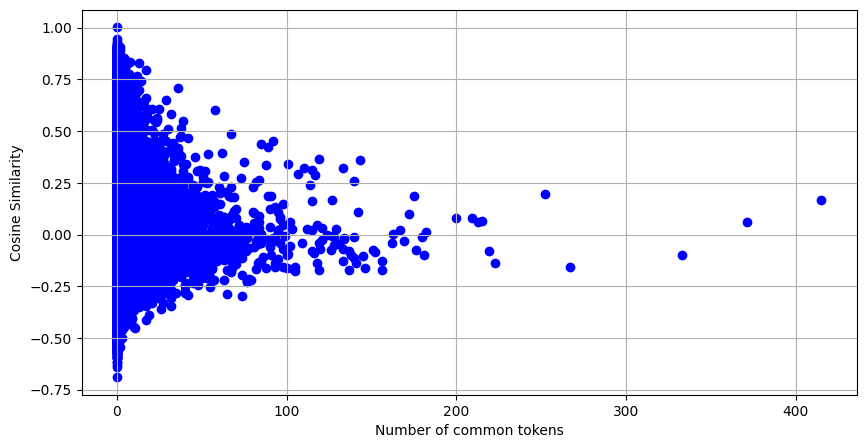

In [70]:
import matplotlib.pyplot as plt

# Create two example tensors
x_tensor = num_common_tokens_ut  # A tensor for the x-axis
y_tensor = dot_products_ut[dot_products_ut!= 0]   # A tensor for the y-axis, as an example using the sine function

# Convert tensors to NumPy arrays
x_array = x_tensor.numpy()
y_array = y_tensor.numpy()

# Plotting the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x_array, y_array, color='blue', marker='o')  # You can customize color and marker type
plt.title('')
plt.xlabel('Number of common tokens')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.show()

In [ ]:
# look at what these features are --- the ones that fire together
# female and python direction might be in the same direction because they never 
# fire together. 

# female and pronoun might be in different directions because otherwise they
# will interfere. 

# features that occur infrequently 
# dot product of 1 and dot product of -1 because they are effectively the same
# direction. just the magnitudes are different. 

# 1 residual stream could be gender. one direction is male, the other is female.
# 

In [56]:
# TODO: figure out the mass, plot the heatmap
# sns jointplot, plt.hist2d 

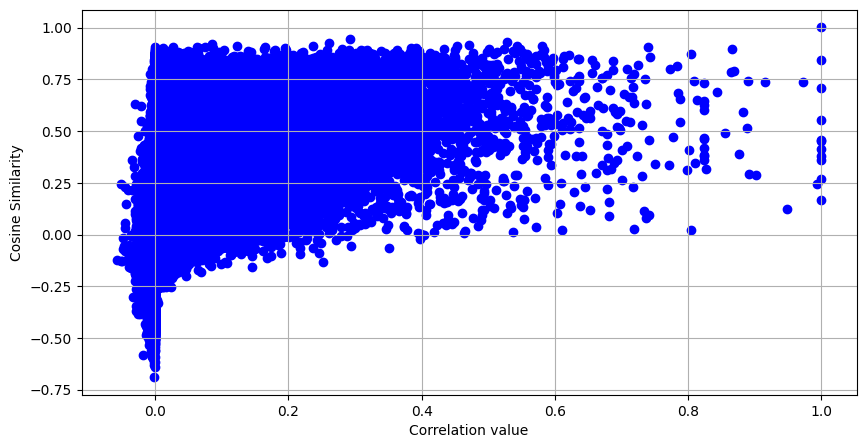

In [26]:
import matplotlib.pyplot as plt

# Create two example tensors
x_tensor = correlation_matrix_ut[correlation_matrix_ut!= 0]  # A tensor for the x-axis
y_tensor = dot_products_ut[dot_products_ut!= 0]   # A tensor for the y-axis, as an example using the sine function

# Convert tensors to NumPy arrays
x_array = x_tensor.numpy()
y_array = y_tensor.numpy()

# Plotting the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x_array, y_array, color='blue', marker='o')  # You can customize color and marker type
plt.title('')
plt.xlabel('Correlation value')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.show()

In [ ]:
# should color one plot with the other.

In [ ]:
# number of sentences on which a pair of features fire
# let us compute the number of sentences on which the features fired at the same time.
# take the dot product of the two vectors used for correlation 

In [27]:
latents1.shape

torch.Size([12288, 4096])

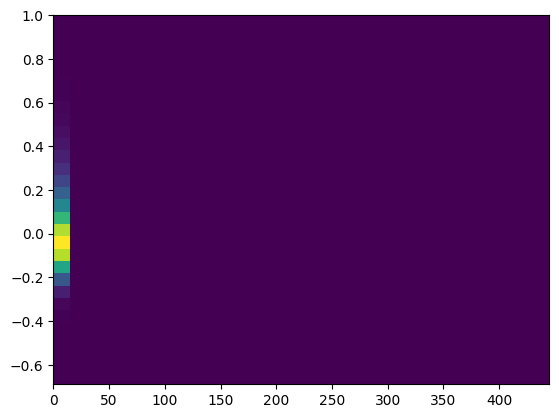

In [60]:
# Make the color scheme more granular
plt.hist2d(x=x_array, y=y_array, bins=30)
plt.show()

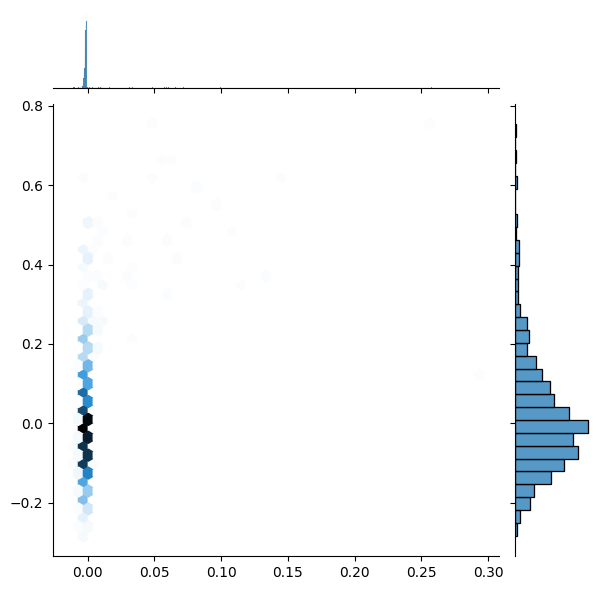

In [22]:
import seaborn as sns 
sns.jointplot(x=x_array[:1000], y=y_array[:1000], kind="hex")

Lessons from this plot:
1. Correlated features tend to be more aligned. When correlation value > 0.5, features almost always have positive cosine similarity.  This is not entirely unexpected as features that are non-orthogonal may actually activate together. More mathematically, if $d_i \cdot d_j > 0$ for some $i, j$, then an activation vector $v$ will likely have non-zero $v.d_i$ and $v.d_j$. A few concerns:

    a. Am I confusing causality and correlation here? 
    
    b. It's not going to be generally true that the converse is true, i.e. if $v.d_i$ and $v.d_j$ are non-zero, then $d_i \cdot d_j > 0$. 

2. Minimum value of cosine similarity is not -1. Instead it is around -0.7, meaning that there are no truly anti-parallel feature vectors.
3. When cosine similarity < -0.2, features are not really correlated with each other. 
4. Around 53 % of the mutual cosine similarities are in the range (-0.1, 0.1). Can we take it to mean that 50% of the pairs are mutually orthogonal? There should be something deeper about it than that.
5. Five pairs have cosine similarity < -0.6. Minimum value is -0.69 for features # 664 and 972. There is not really much one can say about why they have negative cosine similarity by looking at these features.
6. TODO: if there are a lot of zero elements in two tensors, will that increase their activation correlation? In fact, these values being zero mean that there is a large number of tokens for which these features do not fire. So maybe there is no problem with this. 
7. 

In [51]:
torch.where(dot_products_ut == y_array.min())

(tensor([582]), tensor([849]))

In [52]:
alive1[582], alive1[849]

(tensor(664), tensor(972))

In [53]:
dot_products[582, 849]

tensor(-0.6897)

In [40]:
import numpy as np
np.logical_and(y_array < 0.1, y_array > -0.1).shape

(6489003,)

In [43]:
y_array[np.logical_and(y_array < 0.1, y_array > -0.1)].shape[0] / y_array.shape[0]

0.5335526890648686

In [46]:
(y_array < -0.6).sum()

5

In [ ]:
y_array[y_array]

In [36]:
y_array[y_array < 0.1 ]

array([ 0.03682072, -0.12743087, -0.04661825, ..., -0.05224977,
       -0.02802296, -0.00066649], dtype=float32)

In [34]:
# Features that are most correlated with each other
print(correlation_matrix_ut.max(dim=-1).values.topk(k=5))

for i in correlation_matrix_ut.max(dim=-1).values.topk(k=5).indices:
    j = correlation_matrix_ut.max(dim=-1).indices[i]
    print(i, j, correlation_matrix[i, j], dot_products[i, j], alive1[i], alive1[j])

torch.return_types.topk(
values=tensor([1.0000, 1.0000, 1.0000, 0.9966, 0.9936]),
indices=tensor([ 438, 1056,  975, 2409,  173]))
tensor(438) tensor(1360) tensor(1.0000) tensor(1.0021) tensor(498) tensor(1562)
tensor(1056) tensor(2138) tensor(1.0000) tensor(0.1068) tensor(1207) tensor(2426)
tensor(975) tensor(2673) tensor(1.0000) tensor(0.5077) tensor(1114) tensor(3029)
tensor(2409) tensor(2650) tensor(0.9966) tensor(0.1445) tensor(2731) tensor(3001)
tensor(173) tensor(1553) tensor(0.9936) tensor(0.8987) tensor(200) tensor(1774)


In [32]:
# Features that are least correlated with each other.
print(correlation_matrix_ut.min(dim=-1).values.topk(k=5, largest=False))

for i in correlation_matrix_ut.min(dim=-1).values.topk(k=5, largest=False).indices:
    j = correlation_matrix_ut.min(dim=-1).indices[i]
    print(i, j, correlation_matrix[i, j], dot_products[i, j], alive1[i], alive1[j])

torch.return_types.topk(
values=tensor([-0.0615, -0.0406, -0.0353, -0.0331, -0.0330]),
indices=tensor([  25, 2647, 1871, 2871, 1296]))
tensor(25) tensor(2647) tensor(-0.0615) tensor(0.0144) tensor(29) tensor(2998)
tensor(2647) tensor(2871) tensor(-0.0406) tensor(0.2890) tensor(2998) tensor(3260)
tensor(1871) tensor(2647) tensor(-0.0353) tensor(-0.0002) tensor(2133) tensor(2998)
tensor(2871) tensor(3527) tensor(-0.0331) tensor(0.0019) tensor(3260) tensor(4004)
tensor(1296) tensor(2647) tensor(-0.0330) tensor(0.0880) tensor(1485) tensor(2998)


In [ ]:
non_zero_counts = latents1[:, alive1].count_nonzero(dim=0)

In [ ]:
# only 58 values out of 
# only 48 values of which are not equal to each other
non_zero_counts[433], non_zero_counts[1354], (latents1[: ,433] != latents1[:, 1354])

In [97]:
import torch.nn as nn
torch.manual_seed(0)
random_dictionary = nn.Linear(4096, 512).weight

torch.Size([4096, 512])

In [98]:
alive1.shape[0] / 4096

0.8779296875

In [96]:
torch.allclose(dictionary[:, 498], dictionary[:, 1562])

True

In [ ]:
# (433, 1354) correspond to features (498, 1562). Interestingly, they are extremely similar. 
# Is it because my model is not trained well?

<img src="/Users/alishehper/work/monosemantic/assets/Screenshot 2024-05-10 at 1.19.58 PM.png" width="800" height="600" alt="Description of the image">

In [74]:
import plotly.express as px

# Convert to NumPy array if you want to use Matplotlib or for easier handling
non_zero_counts_numpy = non_zero_counts.numpy()

# Create the histogram using Plotly
fig = px.histogram(non_zero_counts_numpy, nbins=50, labels={'value': 'Number of Non-Zero Values'},
                   title='Histogram of Non-Zero Counts in Each Column')
fig.update_layout(xaxis_title='Number of Non-Zero Values', yaxis_title='Frequency')
fig.show()

In [77]:
# Create an array for column indices
column_indices = list(range(non_zero_counts_numpy.shape[0]))

# Create the bar plot using Plotly
fig = px.bar(x=column_indices, y=non_zero_counts_numpy, color_discrete_sequence=['red'],
             labels={'x': 'Column Index', 'y': 'Number of Non-Zero Values'},
             title='Number of Non-Zero Values in Each Column')
fig.update_layout(xaxis_title='Column Index', yaxis_title='Number of Non-Zero Values')
fig.show()

In [88]:
# Create the boxplot using Plotly
fig = px.box(non_zero_counts_numpy, labels={'variable': 'Columns', 'value': 'Non-Zero Counts'},
             title='Boxplot of Non-Zero Counts Across Columns')
fig.update_layout(xaxis_title='Column Data', yaxis_title='Number of Non-Zero Values')
fig.show()

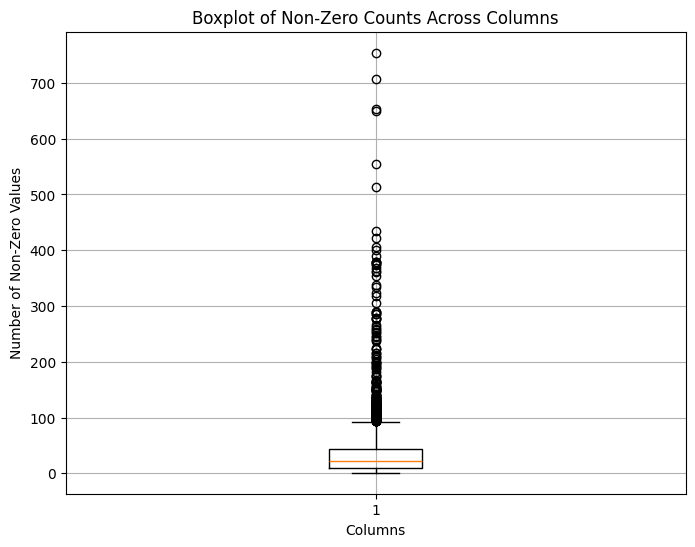

In [89]:
# Create the boxplot using Matplotlib
plt.figure(figsize=(8, 6))  # Set figure size for better visibility
plt.boxplot(non_zero_counts_numpy, vert=True)  # Vertical boxplot
plt.title('Boxplot of Non-Zero Counts Across Columns')
plt.xlabel('Columns')
plt.ylabel('Number of Non-Zero Values')
plt.grid(True)
plt.show()

(tensor(58), tensor(58))

In [ ]:
# Issue: 433 and 1354 fire on very different texts. 

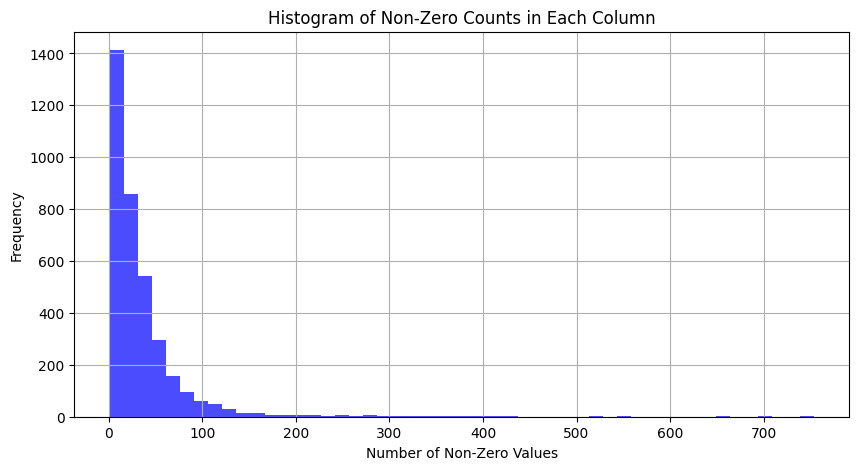

In [72]:


# Plotting the histogram
plt.figure(figsize=(10, 5))
plt.hist(non_zero_counts_numpy, bins=50, color='blue', alpha=0.7)  # Adjust bin size as necessary
plt.title('Histogram of Non-Zero Counts in Each Column')
plt.xlabel('Number of Non-Zero Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [57]:
correlation_matrix[433, 1354]

tensor(1.0000)

In [64]:
dot_products[433, 1354]

tensor(1.0021)

In [48]:
correlation_matrix_ut.max(dim=-1)

torch.return_types.max(
values=tensor([0.2624, 0.3652, 0.6966,  ..., 0.0000, 0.0000, 0.0000]),
indices=tensor([2035, 2420,  828,  ...,    0,    0,    0]))

In [35]:
correlation_matrix.triu(diagonal=1)

tensor([[ 0.0000, -0.0020, -0.0024,  ..., -0.0014,  0.0011, -0.0030],
        [ 0.0000,  0.0000, -0.0012,  ..., -0.0007, -0.0015, -0.0015],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0009, -0.0018, -0.0018],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0010, -0.0011],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0022],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [36]:
dot_products.triu(diagonal=1)

tensor([[ 0.0000,  0.0368,  0.1093,  ..., -0.1175, -0.0046,  0.0587],
        [ 0.0000,  0.0000,  0.0373,  ...,  0.1218,  0.1239,  0.1446],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0284, -0.1629,  0.0163],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.1237,  0.2045],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0007],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])